In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [3]:
ls ../../data

arg-kp/                   our_test.csv
arg-quality/              our_valid.csv
arguments_our_test.csv    train_args_with_scores.pkl
arguments_our_valid.csv   train_topic_keypoints_with_scores.pkl
key_points_our_test.csv   training_df.csv
key_points_our_valid.csv  valid_args_with_scores.pkl
labels_our_test.csv       valid_df.csv
labels_our_valid.csv


In [31]:
training_df = pd.read_csv('../../data/training_df.csv')
valid_df = pd.read_csv('../../data/our_valid.csv')

In [32]:
training_df.key_point.value_counts()

People should be allowed to do whatever they want to their own bodies       132
Alcohol and tobacco are more harmful drugs yet remain legal                 131
Cannabis is safe/healthy/pain-relief                                        130
If cannabis was legalized it could be regulated                             128
Cannabis is financially beneficial                                          127
                                                                           ... 
The government is essential to protect the rights of citizens                64
Intellectual property restricts access to important information/products     61
Religions are immoral and people should not follow them                      61
Men are better suited to combat roles than women                             59
The terminally ill would benefit from assisted suicide                       58
Name: key_point, Length: 207, dtype: int64

In [6]:
training_df.head()

,arg_id,key_point_id,label,argument,topic,stance,key_point
0,arg_0_0,kp_0_0,0,`people reach their limit when it comes to their quality of life and should be able to end their suffering. this can be done with little or no suffering by assistance and the person is able to say good bye.,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
1,arg_0_1,kp_0_0,0,"A patient should be able to decide when they have had enough ""care"".",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
2,arg_0_2,kp_0_0,0,"a person has the right to end their suffering and if somebody takes pity on them and chooses to help, that person should not be punished.",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
3,arg_0_4,kp_0_0,0,a person should have the right to be able to choose if they want to live or die,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
4,arg_0_5,kp_0_0,0,a person should have the right to die on their own terms,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it


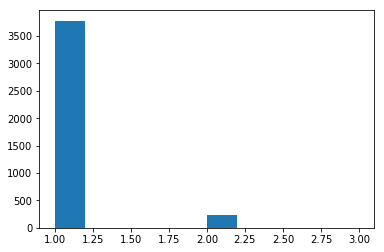

In [6]:
keypoints_per_arg = [x[1] for x in training_df[training_df.label == 1].arg_id.value_counts().to_dict().items()]
plt.hist(keypoints_per_arg)
plt.show()

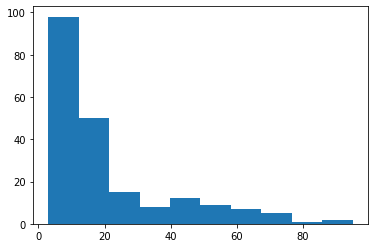

In [118]:
args_per_keypoints = [x[1] for x in training_df[training_df.label == 1].key_point_id.value_counts().to_dict().items()]
plt.hist(args_per_keypoints)
plt.show()

In [ ]:
#Add to the dataframe 0 labels for non-matched argument/keypoint


-------------

### Data Preparation:

In [7]:
import random
import nltk
from nltk.corpus import stopwords

In [8]:
def overlap(t1, t2):
    t1_words = set([w for w in nltk.word_tokenize(t1.lower()) if w not in stopwords.words('english')])
    t2_words = set([w for w in nltk.word_tokenize(t2.lower()) if w not in stopwords.words('english')])
    return len(set(t1_words).intersection(t2_words))/len(t1_words.union(t2_words))

def get_cand_neg(argument, key_points, not_allowed_keypoints, count=3):
    #remove the matching keypoints
    cand_keypoints = [item[1] for item in key_points.items() if item[1] not in not_allowed_keypoints]
    scored_cand_keypoints = sorted([(cp, overlap(cp, argument)) for cp in cand_keypoints], key=lambda x: x[1])
    
    hard_cand_keypoints = scored_cand_keypoints[0:count]
    easy_cand_keypoints = scored_cand_keypoints[-count:]
#     print(argument)
#     print(cand_keypoints[0:10])
#     print('======')
    selected_kp = hard_cand_keypoints + easy_cand_keypoints
    return selected_kp
    
    #return [random.sample(cand_keypoints, count)]

def gen_kp_triplet(labels_df, max_neg_samples=5, sample_extra=False, add_topic=False, randomized=False):
    arguments = pd.Series(labels_df.argument.values, index=labels_df.arg_id).to_dict()
    keypoints= pd.Series(labels_df.key_point.values, index=labels_df.key_point_id).to_dict()

    triplets = []
    for kp_id, keypoint in list(keypoints.items()):
        neg_args = [row['argument'] for idx, row in labels_df[labels_df.key_point_id == kp_id].iterrows() if row['label'] == 0]
        pos_args = [row['argument'] for idx, row in labels_df[labels_df.key_point_id == kp_id].iterrows() if row['label'] == 1]
        
        topic = labels_df[labels_df.key_point_id==kp_id]['topic'].tolist()[0]
        
        if len(pos_args) == 0:
            print('Skipping keypoint with no arguments!')
            continue
       
        
        for pos_arg in pos_args:
            selected_args = []
            if randomized:
                selected_args = random.sample(neg_args, max_neg_samples) if max_neg_samples < len(neg_args) else neg_args
            else:
                if len(neg_args) > (2*max_neg_samples):
                    selected_args = sorted(neg_args, key= lambda x: - overlap(x, pos_arg))
                    selected_args = selected_args[0:max_neg_samples] + selected_args[-max_neg_samples:]
                else:
                    selected_args = neg_args

            #first add the gt negative key-point
            #print(len(neg_args))
            for neg_arg in selected_args:
                if add_topic:
                    topic_with_keypoint = topic+' <SEP> '+keypoint
                    triplets.append([topic_with_keypoint, pos_arg, neg_arg])
                else:
                    triplets.append([keypoint, pos_arg, neg_arg])
    
    return triplets

In [30]:
train_triplets_data = gen_kp_triplet(training_df, max_neg_samples=10, add_topic=True)
#valid_triplets_data = gen_kp_triplet(valid_df, max_neg_samples=1, add_topic=True)
training_triplet_kp_as_anchor_df = pd.DataFrame(train_triplets_data, columns=['anchor', 'pos', 'neg'])
#valid_triplet_kp_as_anchor_df = pd.DataFrame(valid_triplets_data, columns=['anchor', 'pos', 'neg'])
training_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_kp_as_anchor_topic_added_max_20_neg_samples.csv')
#valid_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_kp_as_anchor_topic_added_max_20_neg_samples.csv')

In [31]:
train_triplets_data = gen_kp_triplet(training_df, max_neg_samples=20, add_topic=True)
#valid_triplets_data = gen_kp_triplet(valid_df, max_neg_samples=1, add_topic=True)
training_triplet_kp_as_anchor_df = pd.DataFrame(train_triplets_data, columns=['anchor', 'pos', 'neg'])
#valid_triplet_kp_as_anchor_df = pd.DataFrame(valid_triplets_data, columns=['anchor', 'pos', 'neg'])
training_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_kp_as_anchor_topic_added_max_40_neg_samples.csv')
#valid_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_kp_as_anchor_topic_added_max_40_neg_samples.csv')

In [32]:
train_triplets_data = gen_kp_triplet(training_df, max_neg_samples=5, add_topic=True)
#valid_triplets_data = gen_kp_triplet(valid_df, max_neg_samples=1, add_topic=True)
training_triplet_kp_as_anchor_df = pd.DataFrame(train_triplets_data, columns=['anchor', 'pos', 'neg'])
#valid_triplet_kp_as_anchor_df = pd.DataFrame(valid_triplets_data, columns=['anchor', 'pos', 'neg'])
training_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_kp_as_anchor_topic_added_max_10_neg_samples.csv')
#valid_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_kp_as_anchor_topic_added_max_10_neg_samples.csv')

In [25]:
train_triplets_data = gen_kp_triplet(training_df, max_neg_samples=10, add_topic=True, randomized=True)
#valid_triplets_data = gen_kp_triplet(valid_df, max_neg_samples=1, add_topic=True, randomized=True)
training_triplet_kp_as_anchor_df = pd.DataFrame(train_triplets_data, columns=['anchor', 'pos', 'neg'])
#valid_triplet_kp_as_anchor_df = pd.DataFrame(valid_triplets_data, columns=['anchor', 'pos', 'neg'])
training_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_kp_as_anchor_topic_added_random_10_neg_samples.csv')
#valid_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_kp_as_anchor_topic_added_random_10_neg_samples.csv')

Skipping keypoint with no arguments!


In [41]:
train_triplets_data = gen_kp_triplet(training_df, max_neg_samples=1000, add_topic=True, randomized=True)
#valid_triplets_data = gen_kp_triplet(valid_df, max_neg_samples=1, add_topic=True, randomized=True)
training_triplet_kp_as_anchor_df = pd.DataFrame(train_triplets_data, columns=['anchor', 'pos', 'neg'])
#valid_triplet_kp_as_anchor_df = pd.DataFrame(valid_triplets_data, columns=['anchor', 'pos', 'neg'])
training_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_kp_as_anchor_topic_added_all_neg_samples.csv')
#valid_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_kp_as_anchor_topic_added_random_10_neg_samples.csv')

In [42]:
training_triplet_kp_as_anchor_df.head()

,anchor,pos,neg
0,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,`people reach their limit when it comes to their quality of life and should be able to end their suffering. this can be done with little or no suffering by assistance and the person is able to say good bye.
1,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,"A patient should be able to decide when they have had enough ""care""."
2,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,"a person has the right to end their suffering and if somebody takes pity on them and chooses to help, that person should not be punished."
3,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,a person should have the right to be able to choose if they want to live or die
4,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,a person should have the right to die on their own terms


----------

In [34]:
training_triplet_kp_as_anchor_topic_added_df = pd.read_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_kp_as_anchor_topic_added_max_10_neg_samples.csv')

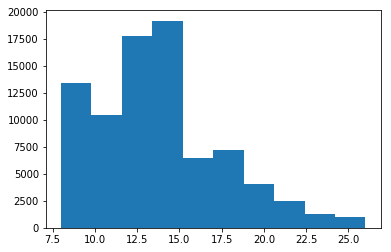

In [35]:
anchor_lengths = [len(x.split()) for x in training_triplet_kp_as_anchor_df.anchor.tolist()]
plt.hist(anchor_lengths)
plt.show()

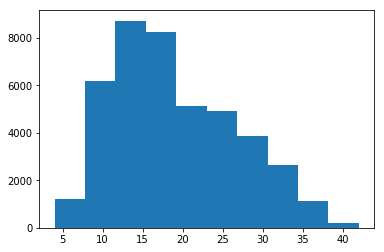

In [37]:
anchor_lengths = [len(x.split()) for x in training_triplet_kp_as_anchor_topic_added_df.pos.tolist()]
plt.hist(anchor_lengths)
plt.show()

In [38]:
training_triplet_kp_as_anchor_topic_added_df.head()

,Unnamed: 0,anchor,pos,neg
0,0,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,people with terminal illnesses are going to die. by not allowing assisted suicide we are making these people suffer deeply which in inhumane.
1,1,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,"assisted suicide is sometimes the only solution for some people, we should not take it off."
2,2,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,"assisted suicide should not be a crime. if someone is suffering on a daily basis from something that they are going to die from anyway, they should be allowed to die on their own terms."
3,3,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,many people face a cruel and protracted period of suffering before their death so with compassion they should be helped therefore assisted suicide should not be a criminal offence.
4,4,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,assisted suicide should not be a crime since the perpetrator was merely obeying the wishes of another.


#### Creating data for the batch-triplet:

In [53]:
map_labels={x[1]: int(x[0]) for x in enumerate(set(training_df.key_point_id.tolist()))}

In [54]:
pos_df = training_df[training_df.label != 0]
pos_arguments = [(x[0], 'arg', x[1], (map_labels[x[1]]*2)) for x in pos_df[['argument', 'key_point_id']].values.tolist()]

kp_seriese = pd.Series(training_df.key_point_id.values, index= training_df.key_point).to_dict()
key_points    = [(x[0], 'kp', x[1], (map_labels[x[1]]*2)+1) for x in kp_seriese.items()]
all_instances_df = pd.DataFrame(pos_arguments + key_points, columns=['text', 'type', 'kp_id', 'label'])

In [55]:
np.random.shuffle(all_instances_df.values)

In [56]:
all_instances_df.head()

,text,type,kp_id,label
0,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,arg,kp_0_0,410
1,assisted suicide allows terminally ill people to die with dignity and should not be criminalized,arg,kp_0_0,410
2,assisted suicide allows terminally ill persons to choose when to die and do it with dignity. it lets people decide not to live in a state of pain and misery and choose to pass on with human intervention.,arg,kp_0_0,410
3,assisted suicide gives people control over their life in terrible circumstances. it allows them dignity in death rather than living in terrible conditions for many years.,arg,kp_0_0,410
4,assisted suicide should be allowed because it allows people with terminal illnesses to die with dignity before suffering a long and painful death.,arg,kp_0_0,410


In [57]:
all_instances_df[['text', 'label']].to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_batch_hard.csv')

In [60]:
#DONT run it because the validation file should be of form argument, pos_keypoint, con_keypoint
# map_labels={x[1]: int(x[0]) for x in enumerate(valid_df.key_point_id.tolist())}
# pos_df = valid_df[valid_df.label != 0]
# pos_arguments = [(x[0], (map_labels[x[1]]*2)+1) for x in pos_df[['argument', 'key_point_id']].values.tolist()]
# key_points    = [(x[0], (map_labels[x[1]]*2)+1) for x in valid_df[['key_point', 'key_point_id']].values.tolist()]

# all_instances_df = pd.DataFrame(pos_arguments + key_points, columns=['text', 'label'])

# all_instances_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_batch_hard.csv')
#valid_triplet_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_batch_hard.csv')

### Creating data for ContrastiveLoss:

In [9]:
training_df.head()

,arg_id,key_point_id,label,argument,topic,stance,key_point
0,arg_0_0,kp_0_0,0,`people reach their limit when it comes to their quality of life and should be able to end their suffering. this can be done with little or no suffering by assistance and the person is able to say good bye.,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
1,arg_0_1,kp_0_0,0,"A patient should be able to decide when they have had enough ""care"".",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
2,arg_0_2,kp_0_0,0,"a person has the right to end their suffering and if somebody takes pity on them and chooses to help, that person should not be punished.",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
3,arg_0_4,kp_0_0,0,a person should have the right to be able to choose if they want to live or die,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
4,arg_0_5,kp_0_0,0,a person should have the right to die on their own terms,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it


In [52]:
df = training_df.copy()
df['keypoint'] = df.apply(lambda x: x['topic'] + ' <SEP> ' + x['key_point'], axis=1)
df['label'] = df.label.apply(lambda x: int(x))
df[['argument', 'keypoint', 'label']].to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_contrastive.csv')

df = valid_df.copy()
df['keypoint'] = df.apply(lambda x: x['topic'] + ' <SEP> ' + x['key_point'], axis=1)
df['label'] = df.label.apply(lambda x: int(x))
df[['argument', 'keypoint', 'label']].to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_contrastive.csv')

In [51]:
df.head()

,Unnamed: 0,arg_id,key_point_id,label,argument,topic,stance,key_point,keypoint
0,0,arg_4_121,kp_4_5,1,"A real education is about giving students the tools to learn, think, and express themselves; dictating to them what to wear sends a strong message that we don't trust them to think on their own.",We should abandon the use of school uniform,1,School uniform is harming the student's self expression,We should abandon the use of school uniform <SEP> School uniform is harming the student's self expression
1,1,arg_4_122,kp_4_5,1,children express themselves through the clothes they wear and should be able to do this at school,We should abandon the use of school uniform,1,School uniform is harming the student's self expression,We should abandon the use of school uniform <SEP> School uniform is harming the student's self expression
2,3,arg_4_124,kp_4_5,1,children should be allowed to express themselves,We should abandon the use of school uniform,1,School uniform is harming the student's self expression,We should abandon the use of school uniform <SEP> School uniform is harming the student's self expression
3,5,arg_4_129,kp_4_5,1,it is not fair to not allow children to express their personality through dress as long as it is appropriate.,We should abandon the use of school uniform,1,School uniform is harming the student's self expression,We should abandon the use of school uniform <SEP> School uniform is harming the student's self expression
4,7,arg_4_131,kp_4_5,1,kids should be able to express them selves with their clothing,We should abandon the use of school uniform,1,School uniform is harming the student's self expression,We should abandon the use of school uniform <SEP> School uniform is harming the student's self expression


----------

#### Add augmented data using paraphrases:

In [48]:
para_keypoints_df = pd.read_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/paraphrase-data-augmentation/kp_paraphrased-train.csv')

In [49]:
para_kps = pd.Series(para_keypoints_df.key_point_paraphrase.values, index=para_keypoints_df.key_point_id).to_dict()

In [50]:
train_kps_df = training_df.groupby('key_point_id').agg({'key_point': lambda x: list(x)[0]}).reset_index()

In [51]:
train_kps_df = pd.merge(train_kps_df, para_keypoints_df, on='key_point_id')

In [55]:
train_kps_df.head(n=10)

,key_point_id,key_point,key_point_paraphrase
0,kp_0_0,Assisted suicide gives dignity to the person that wants to commit it,we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
1,kp_0_1,Assisted suicide reduces suffering,it should be up to patients to decide if they have had sufficient health care
2,kp_0_2,People should have the freedom to choose to end their life,a patient should know how much care they need
3,kp_0_3,The terminally ill would benefit from assisted suicide,a person's right to end his suffering is a right that shouldn't be punished to any extent if he gives them pity and helps
4,kp_0_4,Assisted suicide allows people to solicit someone to die to their own benefit,a cure or treatment may be discovered short after someone has unnecessarily ended their life
5,kp_0_5,Assisted suicide is akin to killing someone,a cure or treatment can be discovered just after an unnecessarily long death
6,kp_0_6,Assisted suicide should not be allowed because many times people can still get better,a cure may be found shortly after someone's unnecessarily tragic death
7,kp_0_7,Assisted suicide violates the doctor's role,a cure or treatment may be discovered in the immediate aftermath of an unnecessarily tragic end
8,kp_0_8,People do not have the right to self-harm/harm others,soon after ending one's life unnecessarily a cure or treatment may occur
9,kp_0_9,People who are ill do not have clear judgement and are in need of help,a cure may be discovered when a person's life was ending unnecessarily


In [41]:
original_df.keypoint.value_counts()

We should legalize cannabis <SEP> People should be allowed to do whatever they want to their own bodies                          132
We should legalize cannabis <SEP> Alcohol and tobacco are more harmful drugs yet remain legal                                    131
We should legalize cannabis <SEP> Cannabis is safe/healthy/pain-relief                                                           130
We should legalize cannabis <SEP> If cannabis was legalized it could be regulated                                                128
We should fight urbanization <SEP> Urbanization causes crime                                                                     127
                                                                                                                                ... 
We should adopt libertarianism <SEP> The government is essential to protect the rights of citizens                                64
We should abolish intellectual property rights <SEP> Intellectual pro

In [42]:
para_df.keypoint.value_counts()

We should fight urbanization <SEP> concentrating large number of people and resources increases pollution and lessons the feeling of wellbeing among it's citizens.                                                            352
We should abandon marriage <SEP> "marriage" isn't keeping up with the times. abandon the old thinking and bring something that incorporates all unions - not just those with a man and woman.                                  221
We should prohibit women in combat <SEP> an enemy can not attack to see that the opponent is a woman, an ally could act recklessly if the partner to save is a woman, as you see it is an abuse to the figure of the woman.    155
We should legalize cannabis <SEP> move from alcohol to marijuana will decrease crime because alcohol is ten times more prone to crime and violence than marijuana                                                              132
We should legalize cannabis <SEP> a recent study has indicated that recreational marijuana u

In [38]:
original_df = training_df.copy()
original_df['keypoint'] = original_df.apply(lambda x: x['topic'] + ' <SEP> ' + x['key_point'], axis=1)
original_df['label'] = original_df.label.apply(lambda x: int(x))

para_df = training_df.copy()
para_df['keypoint'] = para_df.apply(lambda x: x['topic'] + ' <SEP> ' + para_kps[x['key_point_id']], axis=1)
para_df['label'] = para_df.label.apply(lambda x: int(x))

In [23]:
original_df.head(n=50)

,arg_id,key_point_id,label,argument,topic,stance,key_point,keypoint
0,arg_0_0,kp_0_0,0,`people reach their limit when it comes to their quality of life and should be able to end their suffering. this can be done with little or no suffering by assistance and the person is able to say good bye.,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it
1,arg_0_1,kp_0_0,0,"A patient should be able to decide when they have had enough ""care"".",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it
2,arg_0_2,kp_0_0,0,"a person has the right to end their suffering and if somebody takes pity on them and chooses to help, that person should not be punished.",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it
3,arg_0_4,kp_0_0,0,a person should have the right to be able to choose if they want to live or die,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it
4,arg_0_5,kp_0_0,0,a person should have the right to die on their own terms,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it
5,arg_0_6,kp_0_0,0,"a person should not be forced into having to live their lives suffering, when death is already enevitable",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it
6,arg_0_7,kp_0_0,0,assisted suicide allows for a person who is sick and fully understanding what is done to end their pain when no quality of life can be assured,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it
7,arg_0_8,kp_0_0,0,assisted suicide allows one to end terminal pain and suffering and should be allowed to continue.,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it
8,arg_0_9,kp_0_0,1,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it
9,arg_0_10,kp_0_0,1,assisted suicide allows terminally ill people to die with dignity and should not be criminalized,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> Assisted suicide gives dignity to the person that wants to commit it


In [24]:
para_df.head(n=50)

,arg_id,key_point_id,label,argument,topic,stance,key_point,keypoint
0,arg_0_0,kp_0_0,0,`people reach their limit when it comes to their quality of life and should be able to end their suffering. this can be done with little or no suffering by assistance and the person is able to say good bye.,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
1,arg_0_1,kp_0_0,0,"A patient should be able to decide when they have had enough ""care"".",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
2,arg_0_2,kp_0_0,0,"a person has the right to end their suffering and if somebody takes pity on them and chooses to help, that person should not be punished.",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
3,arg_0_4,kp_0_0,0,a person should have the right to be able to choose if they want to live or die,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
4,arg_0_5,kp_0_0,0,a person should have the right to die on their own terms,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
5,arg_0_6,kp_0_0,0,"a person should not be forced into having to live their lives suffering, when death is already enevitable",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
6,arg_0_7,kp_0_0,0,assisted suicide allows for a person who is sick and fully understanding what is done to end their pain when no quality of life can be assured,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
7,arg_0_8,kp_0_0,0,assisted suicide allows one to end terminal pain and suffering and should be allowed to continue.,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
8,arg_0_9,kp_0_0,1,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it,Assisted suicide should be a criminal offence <SEP> we must all be able to end our suffering by helping us not causing any suffering but by telling others good bye
9,arg_0_10,kp_0_0,1,assisted suicide allows terminally ill people to die with dignity and should not be criminalized,Assisted suicide should 

In [ ]:
df[['argument', 'keypoint', 'label']].to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_contrastive.csv')

---------

#### Train on the AMR trees:

In [102]:
train_amr_df = pd.read_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/amr-trees/training_df_amr.csv')
our_valid_amr_df = pd.read_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/amr-trees/our_valid_amr.csv')
our_test_amr_df = pd.read_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/amr-trees/our_test_amr.csv')

In [126]:
ls /workspace/keypoint-analysis-sharedtask/data/

arg-kp/                       labels_our_test.csv
arg-quality/                  labels_our_valid.csv
arguments_our_amr_test.csv    our_test.csv
arguments_our_amr_valid.csv   our_valid.csv
arguments_our_test.csv        train_args_with_scores.pkl
arguments_our_valid.csv       train_topic_keypoints_with_scores.pkl
key_points_our_amr_test.csv   training_df.csv
key_points_our_amr_valid.csv  valid_args_with_scores.pkl
key_points_our_test.csv       valid_df.csv
key_points_our_valid.csv


In [127]:
#This all to get our_test and our_valid dataframes with amr trees

valid_amr_df = pd.concat([our_test_amr_df, our_valid_amr_df])
arg_amrs_dict = pd.Series(valid_amr_df.amr_arg.values, index=valid_amr_df.arg_id).to_dict()
kp_amrs_dict = pd.Series(valid_amr_df.amr_kp.values, index=valid_amr_df.key_point_id).to_dict()

arguments_our_test_df = pd.read_csv('/workspace/keypoint-analysis-sharedtask/data/arguments_our_test.csv')
arguments_our_valid_df = pd.read_csv('/workspace/keypoint-analysis-sharedtask/data/arguments_our_valid.csv')
keypoints_our_valid_df = pd.read_csv('/workspace/keypoint-analysis-sharedtask/data/key_points_our_valid.csv')
keypoints_our_test_df  = pd.read_csv('/workspace/keypoint-analysis-sharedtask/data/key_points_our_test.csv')
labels_our_test_df = pd.read_csv('/workspace/keypoint-analysis-sharedtask/data/labels_our_test.csv')
labels_our_valid_df = pd.read_csv('/workspace/keypoint-analysis-sharedtask/data/labels_our_valid.csv')

arguments_our_test_df['argument'] = arguments_our_test_df.arg_id.apply(lambda x: arg_amrs_dict[x])
arguments_our_valid_df['argument'] = arguments_our_valid_df.arg_id.apply(lambda x: arg_amrs_dict[x])
keypoints_our_test_df['argument'] = keypoints_our_test_df.key_point_id.apply(lambda x: kp_amrs_dict[x])
keypoints_our_valid_df['argument'] = keypoints_our_valid_df.key_point_id.apply(lambda x: kp_amrs_dict[x])

arguments_our_test_df.to_csv('/workspace/keypoint-analysis-sharedtask/data/arguments_our_amr_test.csv')
arguments_our_valid_df.to_csv('/workspace/keypoint-analysis-sharedtask/data/arguments_our_amr_valid.csv')
keypoints_our_test_df.to_csv('/workspace/keypoint-analysis-sharedtask/data/key_points_our_amr_test.csv')
keypoints_our_test_df.to_csv('/workspace/keypoint-analysis-sharedtask/data/key_points_our_amr_valid.csv')
labels_our_test_df.to_csv('/workspace/keypoint-analysis-sharedtask/data/labels_our_amr_test.csv')
labels_our_valid_df.to_csv('/workspace/keypoint-analysis-sharedtask/data/labels_our_amr_valid.csv')

In [122]:
train_amr_df['argument'] = train_amr_df.amr_arg.apply(lambda x: ''.join(x.split('\n')[1:]) if type(x) != float else None)
train_amr_df['amr_kp'] = train_amr_df.amr_kp.apply(lambda x: ''.join(x.split('\n')[1:]) if type(x) != float else None)

In [123]:
df = train_amr_df.copy()
df['keypoint'] = df.apply(lambda x: x['topic'] + ' <SEP> ' + x['amr_kp'], axis=1)
df['label'] = df.label.apply(lambda x: int(x))
df[['argument', 'keypoint', 'label']].to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_amr.csv')

In [124]:
valid_amr_df['argument'] = valid_amr_df.amr_arg.apply(lambda x: ''.join(x.split('\n')[1:]) if type(x) != float else None)
valid_amr_df['amr_kp'] = valid_amr_df.amr_kp.apply(lambda x: ''.join(x.split('\n')[1:]) if type(x) != float else None)

In [125]:
df = valid_amr_df.copy()
df['keypoint'] = df.apply(lambda x: x['topic'] + ' <SEP> ' + x['amr_kp'], axis=1)
df['label'] = df.label.apply(lambda x: int(x))
df[['argument', 'keypoint', 'label']].to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_amr.csv')